In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"

In [2]:
import itertools
from datetime import datetime
from dataclasses import dataclass
from typing import Optional, Union

import submitit 
from pathlib import Path
import torch

from auto_circuit.tasks import (
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    TASK_DICT,
    Task
)
from auto_circuit_tests.utils.utils import repo_path_to_abs_path, OUTPUT_DIR, RESULTS_DIR
from auto_circuit_tests.tasks import IOI_TOKEN_CIRCUIT_TASK
from auto_circuit.types import AblationType
from auto_circuit_tests.score_funcs import GradFunc, AnswerFunc
from auto_circuit_tests.prune_algos import PruneAlgo
from auto_circuit.prune_algos.activation_patching import compute_loss
from auto_circuit.utils.custom_tqdm import tqdm


/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Specify Settings / Hyperpameters

In [3]:
@dataclass 
class Experiment:
    task: Task 
    algo: PruneAlgo 
    ablation_type: AblationType
    grad_func: GradFunc
    answer_func: AnswerFunc
    ig_samples: Optional[int] = None 
    layerwise: bool = False

def exp_to_dict(exp: Union[Experiment, dict]) -> dict:
    if isinstance(exp, dict):
        return exp
    return {
        "task": f"'{exp.task.key}'", 
        "prune_algo": exp.algo.name, 
        "ablation_type": exp.ablation_type.name, 
        "grad_func": exp.grad_func.name, 
        "answer_func": exp.answer_func.name, 
        "ig_samples": exp.ig_samples, 
        "layerwise": exp.layerwise
    }

# out answer funcs
grad_funcs = [
    GradFunc.LOGIT, 
    GradFunc.LOGPROB
]
answer_funcs = [
    AnswerFunc.MAX_DIFF, 
    AnswerFunc.AVG_VAL, 
]

answer_funcs_div = [
    AnswerFunc.KL_DIV
]

task_out_answer_funcs = list(zip(grad_funcs, answer_funcs))
ground_truth_out_answer_funcs = [(GradFunc.LOGIT, AnswerFunc.MAX_DIFF)]
model_out_answer_funcs = list(zip([GradFunc.LOGPROB], answer_funcs_div))
out_answer_funcs = task_out_answer_funcs +  model_out_answer_funcs

# tasks
small_tasks = [
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK,
    IOI_COMPONENT_CIRCUIT_TASK
]

all_tasks = small_tasks + [IOI_TOKEN_CIRCUIT_TASK]

# ablation types
ablation_types = [
    AblationType.TOKENWISE_MEAN_CLEAN, 
    AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT, 
    AblationType.TOKENWISE_MEAN_CORRUPT, 
    AblationType.RESAMPLE
]

# ig varients
ig_samples = [50]
layerwises = [True, False]

experiments: list[Experiment] = []
# for activation patching, do everything, except on IOI token only do RESAMPLE ablation
for task in small_tasks:
    for grad_func, answer_func in out_answer_funcs:
        for ablation_type in ablation_types:
            exp = Experiment(task, PruneAlgo.ACT_PATCH, ablation_type, grad_func, answer_func)
            experiments.append(exp)
for grad_func, answer_func in out_answer_funcs:
    exp = Experiment(IOI_TOKEN_CIRCUIT_TASK, PruneAlgo.ACT_PATCH, AblationType.RESAMPLE, grad_func, answer_func)
    experiments.append(exp)
# for all varients of integrated gradients, do everything 
for task in all_tasks:
    for grad_func, answer_func in out_answer_funcs:
        for ablation_type in ablation_types:
            for ig_sample in ig_samples:
                for layerwise in layerwises:
                    exp = Experiment(task, PruneAlgo.ATTR_PATCH, ablation_type, grad_func, answer_func, ig_sample, layerwise)
                    experiments.append(exp)
# for edge attribution patching, do everything except div ans funcs 
for task in all_tasks:
    for grad_func, answer_func in task_out_answer_funcs:
        for ablation_type in ablation_types:
            exp = Experiment(task, PruneAlgo.ATTR_PATCH, ablation_type, grad_func, answer_func)
            experiments.append(exp)
# for acdc, do all tasks except IOI token, only do KL div
for task in small_tasks:
    for grad_func, answer_func in model_out_answer_funcs:
        for ablation_type in ablation_types:
            exp = Experiment(task, PruneAlgo.ACDC, ablation_type, grad_func, answer_func)
            experiments.append(exp)
# for circuit probing, do all tasks, only do KL div
for task in all_tasks:
    for grad_func, answer_func in model_out_answer_funcs:
        for ablation_type in ablation_types:
            exp = Experiment(task, PruneAlgo.CIRC_PROBE, ablation_type, grad_func, answer_func)
            experiments.append(exp)

# Utils for Running Experiments

In [4]:
def build_executor(
    num_jobs_parallel: int = 8,
    timeout_min=60*24, # 24 hours 
    mem_gb=40,
    gres="gpu:1",
    cpus_per_task=4,
) -> submitit.AutoExecutor:
    # setup the executor
    out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_out_logs" / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    out_dir.mkdir(exist_ok=True, parents=True)
    executor = submitit.AutoExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=timeout_min,
        mem_gb=mem_gb,
        gres=gres,
        cpus_per_task=cpus_per_task,
        nodes=1,
        slurm_qos="high", 
        slurm_array_parallelism=num_jobs_parallel
    )
    return executor

def run_batch_executor(
    executor: submitit.AutoExecutor, 
    exp_configs: list[Union[Experiment, dict]], 
    script_name: str
) -> list[submitit.Job]:
    # run the jobs
    with executor.batch():
        jobs = []
        for exp_config in exp_configs:
            function = submitit.helpers.CommandFunction(
                ["python", script_name] + [
                    f"{key}={value if value is not None else 'null'}" 
                    for key, value in exp_to_dict(exp_config).items()
                ], 
                cwd=repo_path_to_abs_path(".")
            )
            jobs.append(executor.submit(function))
    return jobs

# Run Activation Patching

## IOI Token Resample

In [5]:
# ioi token circuit resample act patching (very slow, split across jobs, only run on resample)
import math
partitions = 8 
task = IOI_TOKEN_CIRCUIT_TASK
ablation_type = AblationType.RESAMPLE
edge_range = math.ceil(task.model.n_edges / partitions)
edge_starts = [j * edge_range for j in range(partitions)]
ioi_act_patch_combos = [
    {
        "task": f"'{task.key}'", 
        "ablation_type": AblationType.RESAMPLE.name, 
        "edge_start": edge_start, 
        "edge_range": edge_range
    }
    for edge_start in edge_starts
]

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


KeyboardInterrupt: 

In [9]:
excecuter = build_executor(
    num_jobs_parallel=8, 
    timeout_min=60*96, # 4 days
)

jobs = run_batch_executor(
    excecuter, 
    ioi_act_patch_combos, 
    "compute_act_patch_prune_scores.py"
)

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [13]:
print(jobs[0].state)
print(jobs[0].stderr())

RUNNING
/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(

Full Model Loss          | 0/1 [00:00<?, ?it/s]
Full Model Loss██████████| 1/1 [00:00<00:00,  2.98it/s]
Full Model Loss██████████| 1/1 [00:00<00:00,  2.98it/s]

Edge Ablation Loss          | 0/52798 [00:00<?, ?it/s]
Edge Ablation Loss          | 1/52798 [00:02<35:17:51,  2.41s/it]
Edge Ablation Loss          | 2/52798 [00:04<28:17:59,  1.93s/it]
Edge Ablation Loss          | 3/52798 [00:05<26:04:24,  1.78s/it]
Edge Ablation Loss          | 4/52798 [00:07<25:01:48,  1.71s/it]
Edge Ablation Loss          | 5/52798 [00:08<24:25:59,  1.67s/it]
Edge Ablatio

In [15]:
# aggregate scores across partitions, compute and save prune scores
from typing import Dict, Tuple
from auto_circuit.types import PruneScores
task_dir =  RESULTS_DIR / task.key.replace(' ', '_')
ablation_dir = task_dir / ablation_type.name

prune_score_dict: Dict[Tuple[GradFunc, AnswerFunc], PruneScores] = {
    (grad_func, answer_func): task.model.new_prune_scores()
    for grad_func, answer_func in out_answer_funcs
}
# iterate over output and grad func
for grad_func, answer_func in out_answer_funcs:
    prune_scores = task.model.new_prune_scores()
    out_answer_dir = ablation_dir / f"{grad_func.name}_{answer_func.name}"
    # iterate over the edge starts
    for edge_start in edge_starts:
       # load scores 
       score_part = torch.load(out_answer_dir / f"act_patch_prune_scores_{edge_start}_{edge_range}.pt", map_location=task.device)
       for mod_name, score in score_part.items():
            prune_scores[mod_name] += score
    prune_score_dict[(grad_func, answer_func)] = prune_scores

/tmp/ipykernel_3867711/1759561621.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score_part = torch.load(out_answer_dir / f"act_patch_prune_scores_{edge_start}_{edge_r

In [17]:
for (grad_func, answer_func), prune_scores in prune_score_dict.items():
    out_answer_dir = ablation_dir / f"{grad_func.name}_{answer_func.name}"
    torch.save(prune_scores, ablation_dir / out_answer_dir / "act_patch_prune_scores.pt")

## All Other Tasks and Ablation Types

In [5]:
act_patch_combos = [
    {"task": f"'{task.key}'", "ablation_type": ablation_type.name}
    for task, ablation_type in itertools.product(small_tasks, ablation_types)
]


In [18]:
# build executor
excecuter = build_executor(
    num_jobs_parallel=8, 
    timeout_min=60*48, # 1 days
)
# run batched jobs
jobs = run_batch_executor(
    excecuter, 
    act_patch_combos, 
    "compute_act_patch_prune_scores.py"
)

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [16]:
jobs[0]
print(jobs[0].stdout())
print(jobs[0].stderr())

None
None


# Run Find and Test Circuits

In [6]:
# build executor
excecuter = build_executor(
    num_jobs_parallel=8, 
    timeout_min=60*96, # 4 days
    mem_gb=40
)
# run the jobs
jobs = run_batch_executor(
    excecuter, 
    reversed(experiments), 
    "find_and_test_circuit.py"
)

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [45]:
job = jobs[0]
# read stdout and stderr
print(job.stdout())
print(job.stderr())

submitit INFO (2024-09-30 08:55:09,990) - Starting with JobEnvironment(job_id=478748_0, hostname=ppo.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-09-30 08:55:09,990) - Loading pickle: /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_out_logs/2024-09-30_08-55-08/478748_0_submitted.pkl
The following command is sent: "python find_and_test_circuit.py task='Indirect Object Identification Token Circuit' prune_algo=CIRC_PROBE ablation_type=RESAMPLE grad_func=LOGPROB answer_func=KL_DIV ig_samples=null layerwise=False"




# Analyze Results

In [25]:
AGG_RESULTS_DIR = OUTPUT_DIR / "hypo_test_aggregated_results"
AGG_RESULTS_DIR.mkdir(exist_ok=True, parents=True)

In [8]:
from auto_circuit_tests.utils.utils import get_exp_dir
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def format_task_name(task_key: str) -> str:
    task_key = task_key.replace("Indirect Object Identification", "IOI")
    # task_key = task_key.replace("Greater Than", ">")
    task_key = task_key.replace("Circuit", "")
    return task_key

In [10]:
def get_exp_dir_from_exp(exp: Experiment) -> Path:
    return get_exp_dir(
        exp.task.key, 
        exp.ablation_type, 
        exp.grad_func, 
        exp.answer_func, 
        exp.algo, 
        exp.ig_samples, 
        exp.layerwise, 
        0.05, 
        0.1, 
        0.1, 
        False
    )[4]

def get_exp_key(exp: Experiment) -> tuple:
    return (exp.task.key, exp.ablation_type, exp.grad_func, exp.answer_func, exp.algo.name, exp.ig_samples, exp.layerwise)

In [11]:
n_edges_save_path = OUTPUT_DIR / "n_edges.json"
if n_edges_save_path.exists():
    with open(n_edges_save_path, "r") as f:
        n_edges = json.load(f)
else:
    n_edges = {task.key: task.model.n_edges for task in all_tasks}
    with open(n_edges_save_path, "w") as f:
        json.dump(n_edges, f)

# Faithfulness

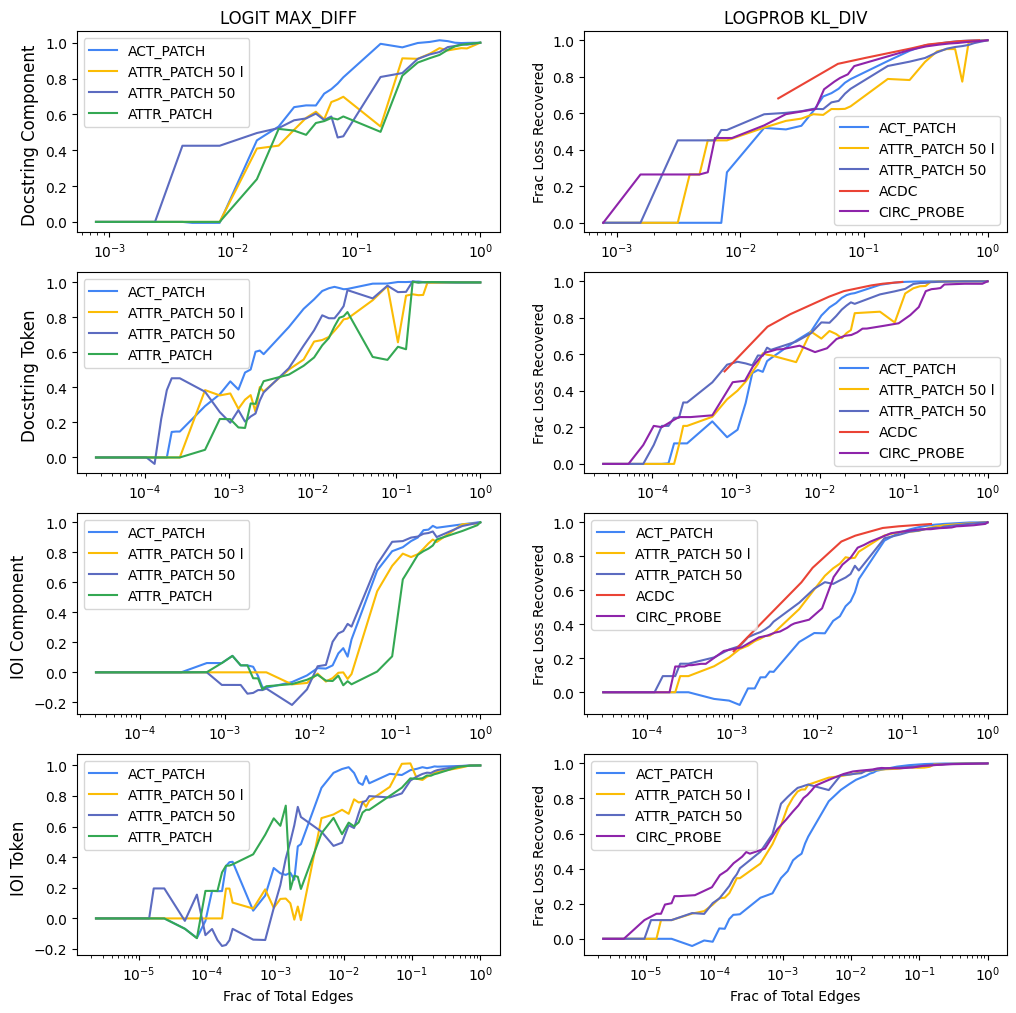

In [12]:
# grid, bottom is task, left is out annswer function (logit max diff and logprob kl div)
# plot faithfulness metrics for all values 

algo_color_map = {
    (PruneAlgo.ACT_PATCH, None, False): "#4285F4",  # Google Blue
    (PruneAlgo.ATTR_PATCH, None, False): "#34A853",  # Google Green
    (PruneAlgo.ATTR_PATCH, 50, True): "#FBBC05",    # Google Yellow
    (PruneAlgo.ATTR_PATCH, 50, False): "#5C6BC0",   # Indigo
    (PruneAlgo.ACDC, None, False): "#EA4335",       # Google Red
    (PruneAlgo.CIRC_PROBE, None, False): "#8E24AA"  # Deep Purple
}

# load all the results and plot 
fig, axs = plt.subplots(len(all_tasks), len(ground_truth_out_answer_funcs + model_out_answer_funcs), figsize=(12, 12))
faith_results = {}
for i, task in enumerate(all_tasks): 
    for j, (grad_func, answer_func) in enumerate(ground_truth_out_answer_funcs + model_out_answer_funcs): 
        exp_subset = [
            exp for exp in experiments 
            if exp.task == task and exp.grad_func == grad_func and exp.answer_func == answer_func and  \
            exp.ablation_type == AblationType.RESAMPLE
        ]
        for exp in exp_subset:
            exp_dir = get_exp_dir_from_exp(exp)
            faith_result: dict = json.load(open(exp_dir / "faith_metric_results_train.json", 'r'))
            edge_counts = sorted([int(k) for k in faith_result.keys()])
            max_edges = n_edges[task.key]
            frac_edges = [edge_count / max_edges for edge_count in edge_counts]
            frac_loss_recovered = [faith_result[str(edge_count)]["frac_mean_diff_recovered"] for edge_count in edge_counts]
            faith_results[get_exp_key(exp)] = faith_result
            # plot the results
            label = str(exp.algo.name) + (f" {exp.ig_samples}" if exp.ig_samples is not None else "") + (" l" if exp.layerwise else "")
            color = algo_color_map[(exp.algo, exp.ig_samples, exp.layerwise)]
            axs[i, j].plot(frac_edges, frac_loss_recovered, label=label, color=color)
            if i == 0:
                axs[i, j].set_title(f"{grad_func.name} {answer_func.name}", size=12)
            if j == 0:
                axs[i, j].set_ylabel(format_task_name(task.key), size=12)
            if i == len(all_tasks) - 1:
                axs[i, j].set_xlabel("Frac of Total Edges")
            if j ==1:
                axs[i,j].set_ylabel("Frac Loss Recovered")
            # axs[i, j].set_title(f"{task.key} {grad_func.name}")
            axs[i, j].set_xscale("log")
            # axs[i, j].set_ylabel("Frac Loss Recovered")
            axs[i, j].legend()

/tmp/ipykernel_3497586/1062239999.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i, j].legend()


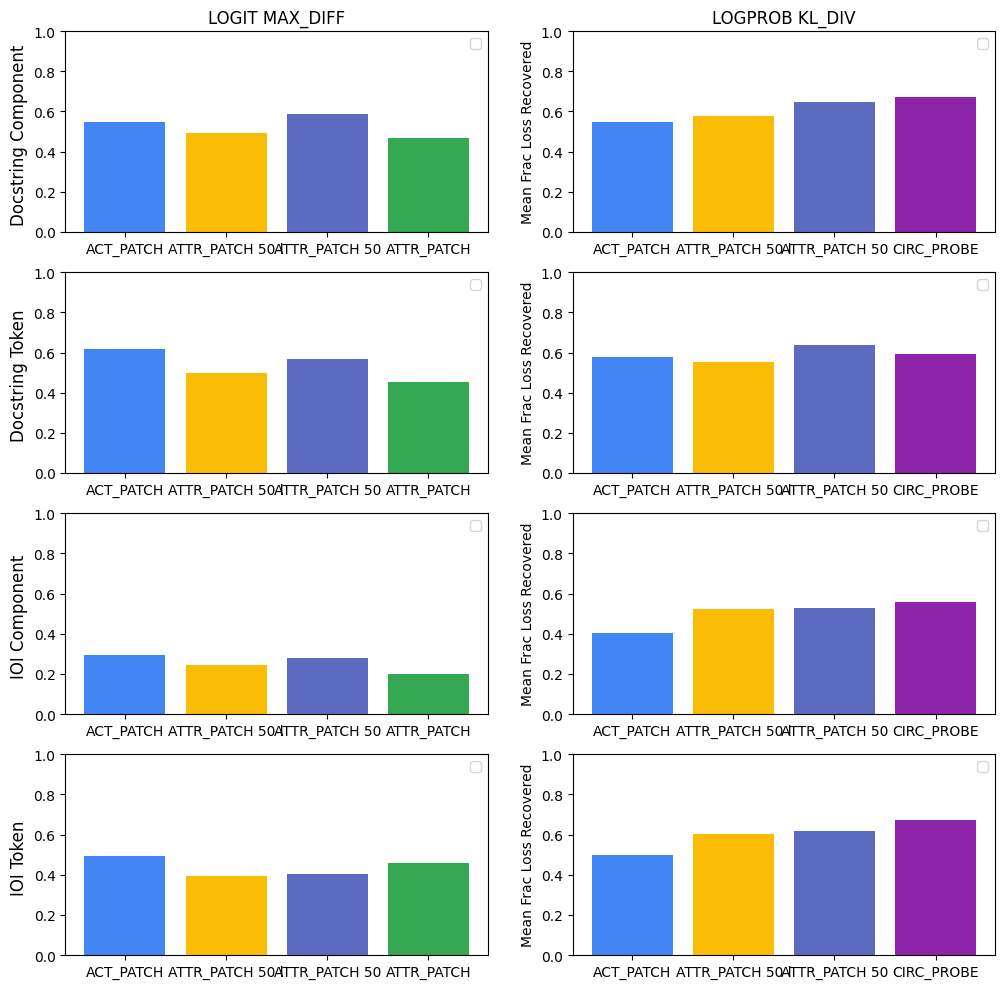

In [93]:
# I think instead I should ust report in a table, diffrent table for each ablation type in appendix, bold the best result for each out and grad func
# plot mean frac of loss recovered (except for ACDC)
fig, axs = plt.subplots(len(all_tasks), len(ground_truth_out_answer_funcs + model_out_answer_funcs), figsize=(12, 12))
for i, task in enumerate(all_tasks): 
    for j, (grad_func, answer_func) in enumerate(ground_truth_out_answer_funcs + model_out_answer_funcs): 
        exp_subset = [
            exp for exp in experiments 
            if exp.task == task and exp.grad_func == grad_func and exp.answer_func == answer_func and  \
            exp.ablation_type == AblationType.RESAMPLE and exp.algo != PruneAlgo.ACDC
        ]
        for exp in exp_subset:
            exp_dir = get_exp_dir_from_exp(exp)
            faith_result: dict = json.load(open(exp_dir / "faith_metric_results_train.json", 'r'))
            edge_counts = sorted([int(k) for k in faith_result.keys()])
            max_edges = n_edges[task.key]
            frac_edges = [edge_count / max_edges for edge_count in edge_counts]
            frac_loss_recovered = [faith_result[str(edge_count)]["frac_mean_diff_recovered"] for edge_count in edge_counts]
            # plot the results
            label = str(exp.algo.name) + (f" {exp.ig_samples}" if exp.ig_samples is not None else "") + (" l" if exp.layerwise else "")
            color = algo_color_map[(exp.algo, exp.ig_samples, exp.layerwise)]
            # n_small_circuits = len([frac_edge for frac_edge in frac_edges if frac_edge < (0.05 if task.token_circuit else 0.5)])
            mean_frac_loss_recovered = np.mean(frac_loss_recovered)
            axs[i, j].bar(label, mean_frac_loss_recovered, color=color)
            axs[i,j].set_ylim(0, 1)
            if i == 0:
                axs[i, j].set_title(f"{grad_func.name} {answer_func.name}", size=12)
            if j == 0:
                axs[i, j].set_ylabel(format_task_name(task.key), size=12)
            # if i == len(all_tasks) - 1:
            #     axs[i, j].set_xlabel("Frac of Total Edges")
            if j ==1:
                axs[i,j].set_ylabel("Mean Frac Loss Recovered")
            # axs[i, j].set_title(f"{task.key} {grad_func.name}")
            # axs[i, j].set_xscale("log")
            # axs[i, j].set_ylabel("Frac Loss Recovered")
            axs[i, j].legend()

# Completeness

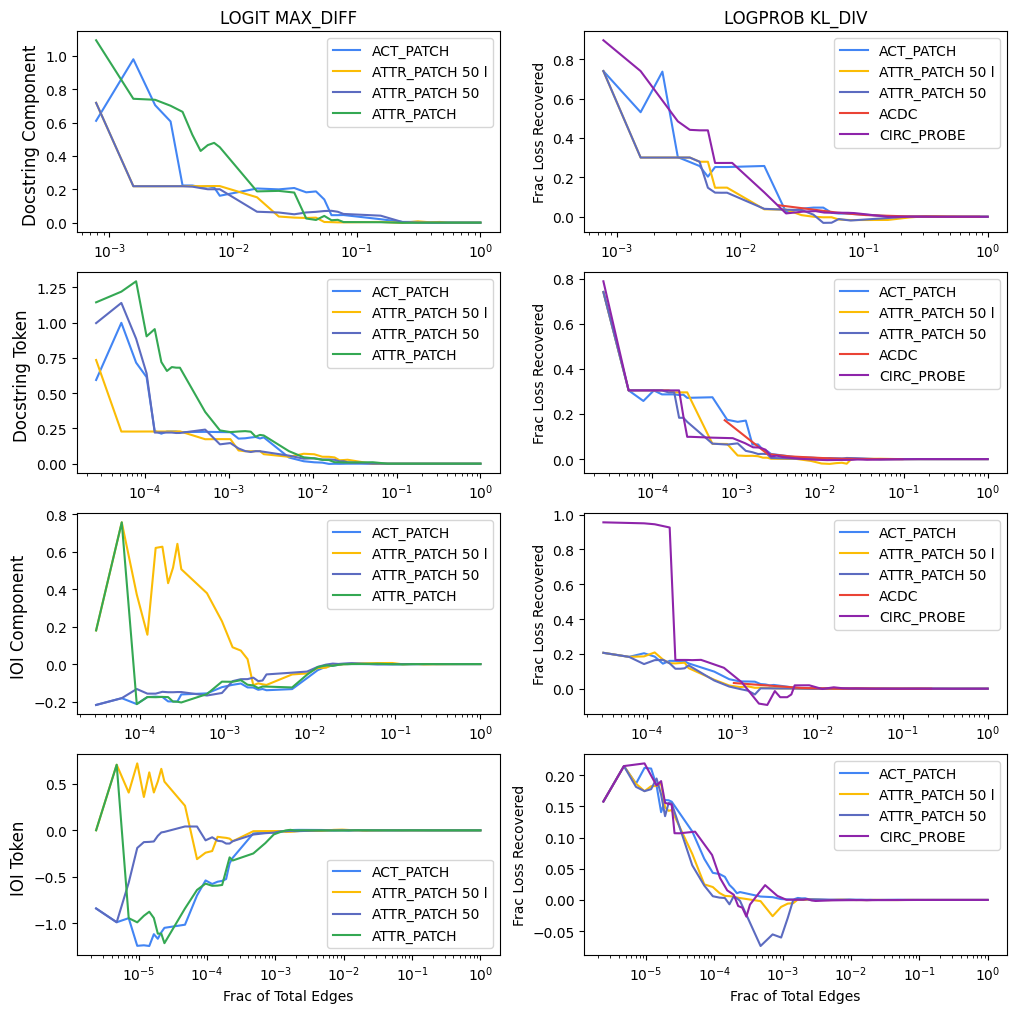

In [87]:
# grid, bottom is task, left is out annswer function (logit max diff and logprob kl div)
# plot faithfulness metrics for all values 

algo_color_map = {
    (PruneAlgo.ACT_PATCH, None, False): "#4285F4",  # Google Blue
    (PruneAlgo.ATTR_PATCH, None, False): "#34A853",  # Google Green
    (PruneAlgo.ATTR_PATCH, 50, True): "#FBBC05",    # Google Yellow
    (PruneAlgo.ATTR_PATCH, 50, False): "#5C6BC0",   # Indigo
    (PruneAlgo.ACDC, None, False): "#EA4335",       # Google Red
    (PruneAlgo.CIRC_PROBE, None, False): "#8E24AA"  # Deep Purple
}

# load all the results and plot 
fig, axs = plt.subplots(len(all_tasks), len(ground_truth_out_answer_funcs + model_out_answer_funcs), figsize=(12, 12))
faith_results = {}
for i, task in enumerate(all_tasks): 
    for j, (grad_func, answer_func) in enumerate(ground_truth_out_answer_funcs + model_out_answer_funcs): 
        exp_subset = [
            exp for exp in experiments 
            if exp.task == task and exp.grad_func == grad_func and exp.answer_func == answer_func and  \
            exp.ablation_type == AblationType.RESAMPLE
        ]
        for exp in exp_subset:
            exp_dir = get_exp_dir_from_exp(exp)
            faith_result: dict = json.load(open(exp_dir / "faith_metric_results_c_train.json", 'r'))
            edge_counts = sorted([int(k) for k in faith_result.keys()])
            max_edges = n_edges[task.key]
            frac_edges = [edge_count / max_edges for edge_count in edge_counts]
            frac_loss_recovered = [faith_result[str(edge_count)]["frac_mean_diff_recovered"] for edge_count in edge_counts]
            faith_results[get_exp_key(exp)] = json.load(open(exp_dir / "faith_metric_results_train.json", 'r'))
            # plot the results
            label = str(exp.algo.name) + (f" {exp.ig_samples}" if exp.ig_samples is not None else "") + (" l" if exp.layerwise else "")
            color = algo_color_map[(exp.algo, exp.ig_samples, exp.layerwise)]
            axs[i, j].plot(frac_edges, frac_loss_recovered, label=label, color=color)
            if i == 0:
                axs[i, j].set_title(f"{grad_func.name} {answer_func.name}", size=12)
            if j == 0:
                axs[i, j].set_ylabel(format_task_name(task.key), size=12)
            if i == len(all_tasks) - 1:
                axs[i, j].set_xlabel("Frac of Total Edges")
            if j ==1:
                axs[i,j].set_ylabel("Frac Loss Recovered")
            # axs[i, j].set_title(f"{task.key} {grad_func.name}")
            axs[i, j].set_xscale("log")
            # axs[i, j].set_ylabel("Frac Loss Recovered")
            axs[i, j].legend()

# Faithfulness of Activation Patching

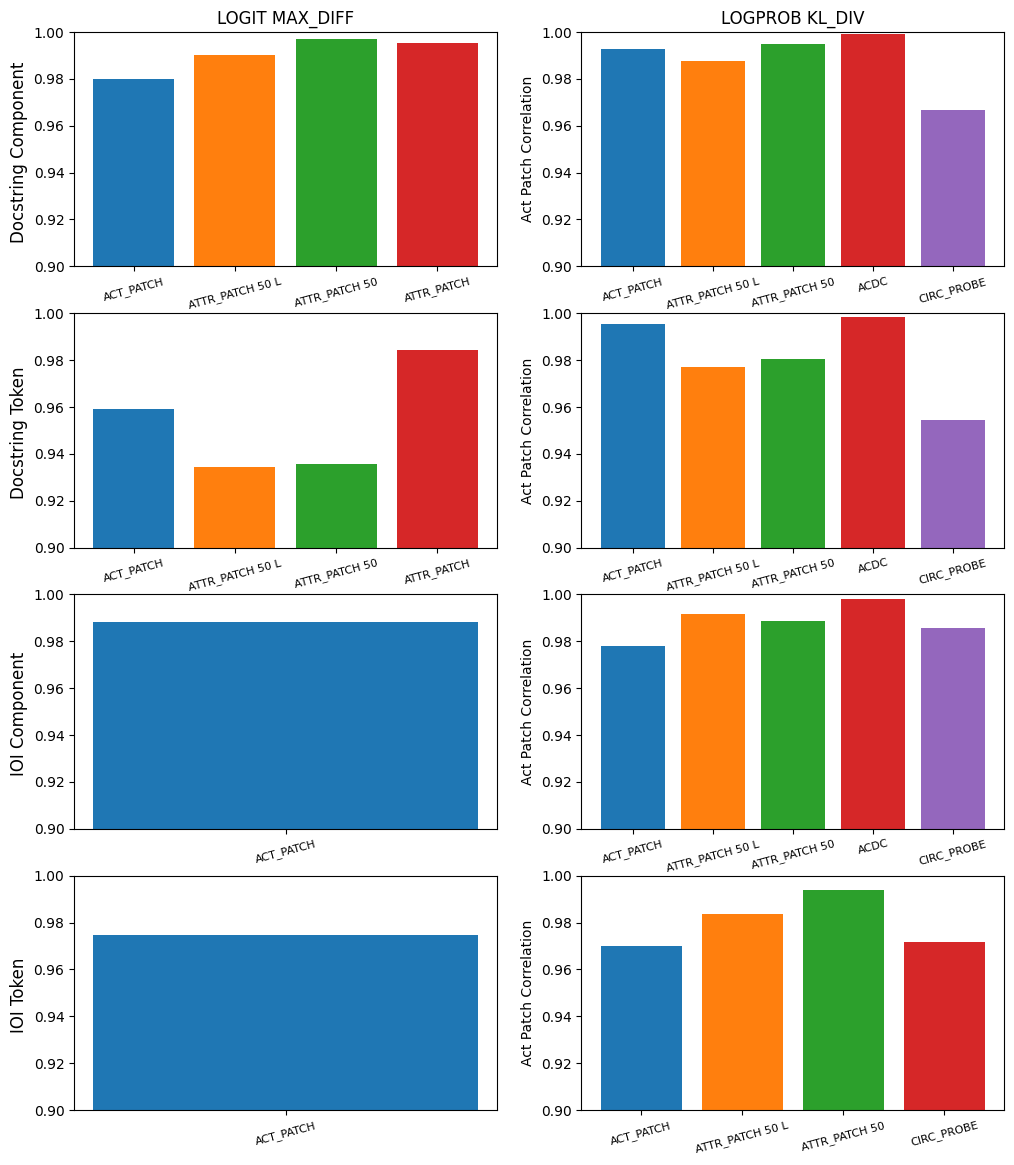

In [81]:
# load all the results and plot 
fig, axs = plt.subplots(len(all_tasks), len(ground_truth_out_answer_funcs + model_out_answer_funcs), figsize=(12, 14))
faith_act_patch_results = {}
for i, task in enumerate(all_tasks): 
    for j, (grad_func, answer_func) in enumerate(ground_truth_out_answer_funcs + model_out_answer_funcs): 
        exp_subset = [
            exp for exp in experiments 
            if exp.task == task and exp.grad_func == grad_func and exp.answer_func == answer_func and  \
            exp.ablation_type == AblationType.RESAMPLE
        ]
        for exp in exp_subset:
            exp_dir = get_exp_dir_from_exp(exp)
            corr_results_path = exp_dir / "circ_act_patch_corr_results.json"
            if not corr_results_path.exists():
                continue
            faith_act_patch_result: dict = json.load(open(corr_results_path, 'r'))
            corr = faith_act_patch_result["corr"]
            # add bar to bar plot 
            label = str(exp.algo.name) + (f" {exp.ig_samples}" if exp.ig_samples is not None else "") + (" L" if exp.layerwise else "")
            # make font size on bar name smaller
            axs[i, j].bar(label, corr)
            labels = axs[i, j].get_xticklabels()
            # axs[i, j].set_xticklabels(labels, rotation=45, ha='right')
            axs[i, j].tick_params(axis='x', labelsize=8, rotation=15)  # Adjust the size as needed
            axs[i,j].set_ylim(0.9, 1)
            # axs[i, j].plot(frac_edges, frac_loss_recovered, label=label, color=color)
            if i == 0:
                axs[i, j].set_title(f"{grad_func.name} {answer_func.name}", size=12)
            if j == 0:
                axs[i, j].set_ylabel(format_task_name(task.key), size=12)
            if j == 1:
                axs[i, j].set_ylabel("Act Patch Correlation")

# Minimality 

In [ ]:
# TODO: can plot change in fraction of loss recovered from ablating each edge in the same way as above 
# can also plot minimality lines, fraction of mininimal edges 

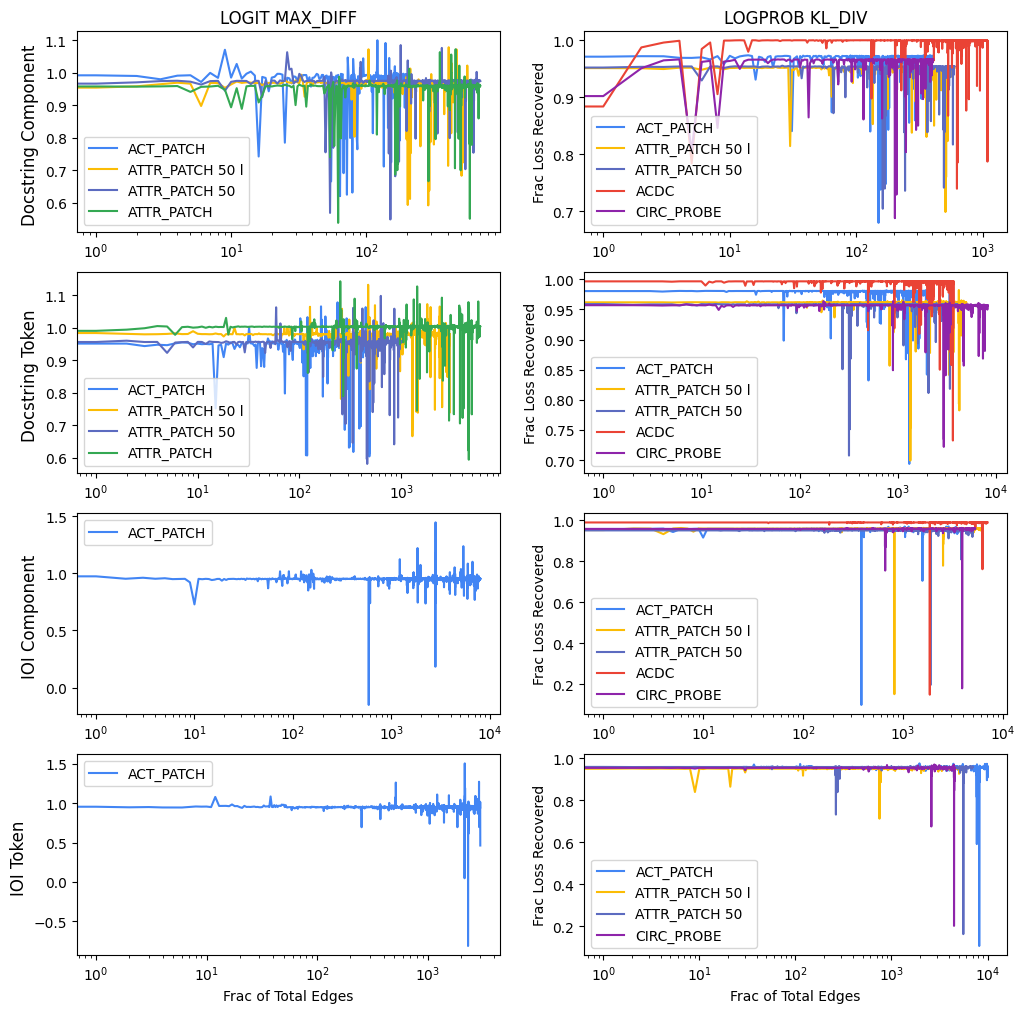

In [25]:
# load all the results and plot 
fig, axs = plt.subplots(len(all_tasks), len(ground_truth_out_answer_funcs + model_out_answer_funcs), figsize=(12, 12))
for i, task in enumerate(all_tasks): 
    for j, (grad_func, answer_func) in enumerate(ground_truth_out_answer_funcs + model_out_answer_funcs): 
        exp_subset = [
            exp for exp in experiments 
            if exp.task == task and exp.grad_func == grad_func and exp.answer_func == answer_func and  \
            exp.ablation_type == AblationType.RESAMPLE
        ]
        for exp in exp_subset:
            exp_dir = get_exp_dir_from_exp(exp)
            edge_results_path = exp_dir / "edge_faith_metric_results_train.json"
            if not edge_results_path.exists():
                continue
            result: dict = json.load(open(edge_results_path, 'r'))
            frac_loss_recovered_by_edge = [result[k]["frac_mean_diff_recovered"] for k in result.keys()]
            # plot the results
            # # plot the results
            label = str(exp.algo.name) + (f" {exp.ig_samples}" if exp.ig_samples is not None else "") + (" l" if exp.layerwise else "")
            color = algo_color_map[(exp.algo, exp.ig_samples, exp.layerwise)]
            axs[i, j].plot(frac_loss_recovered_by_edge, label=label, color=color)
            if i == 0:
                axs[i, j].set_title(f"{grad_func.name} {answer_func.name}", size=12)
            if j == 0:
                axs[i, j].set_ylabel(format_task_name(task.key), size=12)
            if i == len(all_tasks) - 1:
                axs[i, j].set_xlabel("Frac of Total Edges")
            if j ==1:
                axs[i,j].set_ylabel("Frac Loss Recovered")
            # axs[i, j].set_title(f"{task.key} {grad_func.name}")
            axs[i, j].set_xscale("log")
            # axs[i, j].set_ylabel("Frac Loss Recovered")
            axs[i, j].legend()

## Aggregate Data (Old)

In [18]:
def format_name(name: str | bool | float | int)->str:
    name = str(name)
    # set to uppercase for processing 
    name = name.upper()
    # remove TOKENWISE
    if name.startswith("TOKENWISE"):
        name = name[len("TOKENWISE_"):]
    # set MIN_EQUIV to NUM_EDGES 
    if name.startswith("MIN_EQUIV"):
        name = name.replace("MIN_EQUIV", "NUM_EDGES")

    # replace GRAD with OUPTUT 
    if name.startswith("GRAD"):
        name = name.replace("GRAD", "OUTPUT")
    # place FUNC with FUNCTION
    if name.endswith("FUNC"):
        name = name.replace("FUNC", "FUNCTION")
    # replace _ with space
    name = name.replace("_", " ")
    # upper case to title case
    name = name.title()
    return name

In [22]:
import pandas as pd
import json
from auto_circuit_tests.utils import get_exp_dir

ig_default = 10
alpha_default = 0.05
q_star_default = 0.9

# Create a list to store the data
data = []
for combo in combinations:
    task_key = combo["task"][1:-1]  # strip quotes
    ablation_type = AblationType[combo["ablation_type"]]
    grad_func = GradFunc[combo["grad_func"]]
    answer_func = AnswerFunc[combo["answer_func"]]
    use_ab = combo["use_abs"]
    epsilon = combo["epsilon"]
    layerwise = combo['layerwise']
    act_patch = combo['act_patch']
    ig_samples = combo['ig_samples']

    # get path to results 
    task_dir, ablation_dir, out_answer_dir, ps_dir, exp_path = get_exp_dir(
        task_key=task_key, 
        ablation_type=ablation_type, 
        grad_func=grad_func, 
        answer_func=answer_func, 
        ig_samples=ig_samples,# TODO: fix 
        layerwise=layerwise,
        act_patch=act_patch, # TODO: fix
        use_abs=use_ab, 
        alpha=alpha_default, 
        epsilon=epsilon, 
        q_star=q_star_default
    )

    # load equiv test results 
    with open(exp_path / "equiv_test_result.json", "r") as f:
        equiv_test_results: dict[int, dict] = json.load(f)
    
    # load min_equiv results
    min_test_path = exp_path / "min_test_results.json"
    if not min_test_path.exists():
        all_minimal = False
        min_mean_p_value = None
    else:
        with open(min_test_path, "r") as f:
            min_equiv_results: dict[int, dict] = json.load(f)
            all_minimal = all(not v['not_minimal'] for v in min_equiv_results.values())
            min_mean_p_value = sum(v['p_value'] for v in min_equiv_results.values()) / len(min_equiv_results)
    
    # load independence results 
    indep_test_path = exp_path / "indep_result.json"
    if not indep_test_path.exists():
        indep = False
    else:
        with open(exp_path / "indep_result.json", "r") as f:
            indep_test_results: dict[int, dict] = json.load(f)
            indep = not indep_test_results["not_indep"]
            indep_p_value = indep_test_results["p_value"]


    edges_path = exp_path / "edges.json"
    with open(edges_path, "r") as f:
        edges: dict = json.load(f)
    total_edges = TASK_DICT[task_key].model.n_edges
    min_equiv = len(edges)

    # Append the data as a dictionary
    data.append({
        'task_key': task_key,
        'token': "Token" in task_key,  # New index token
        'use_abs': use_ab,
        'epsilon': epsilon,
        'layerwise': layerwise,
        'ig_samples': ig_samples,
        'act_patch': act_patch,
        'ablation_type': ablation_type.name,
        'answer_func': answer_func.name,
        'grad_func': grad_func.name,
        'frac_total_edges': min_equiv / total_edges,
        'min_equiv': min_equiv,
        'total_edges': total_edges, 
        'all_minimal': all_minimal, 
        'min_mean_p_value': min_mean_p_value,
        'indep': indep, 
        'indep_p_value': indep_p_value

    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Set a multi-index
df.set_index(['task_key', 'token', 'use_abs', 'epsilon', 'layerwise', 'ig_samples', 'act_patch', 'ablation_type', 'answer_func', 'grad_func'], inplace=True)

In [ ]:
df

In [ ]:
# TODO: just add df, results to to repo, reference in paper
df.to_csv(AGG_RESULTS_DIR / "hypo_test_results.csv")
df_pretty = df.copy()

# rename 
df_pretty.rename(index=format_name, inplace=True, level='answer_func')
df_pretty.rename(index=format_name, inplace=True, level='grad_func')
df_pretty.rename(index=format_name, inplace=True, level='ablation_type')
df_pretty.rename(index=format_task_name, inplace=True, level='task_key')

# add token vs component index 
df = df_pretty
df.head()
# df_pretty.rename(index="{:.1f}".format, inplace=True, level='epsilon')
# df_pretty.columns = [format_name(col) for col in df_pretty.columns]
# df_pretty.index.names = [format_name(col) for col in df_pretty.index.names]


## Edge Counts for all Tasks, All Partitions

In [27]:
from typing import Literal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, VPacker
import numpy as np
import itertools
from pathlib import Path

def plot_fraction_edges(
    df, 
    dir: Path, 
    fontsize=12, 
    cutoff=0.5,
    scale: Literal['log', 'linear'] = 'log', 
    figsize=(16, 15),
    dpi=100,
    figname='fraction_edges.png'
):
    def limit_image_size(fig, ax, max_size=65000):
        while True:
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            if width <= max_size and height <= max_size:
                break
            fig_size = fig.get_size_inches()
            fig.set_size_inches(fig_size[0] * 0.9, fig_size[1] * 0.9)
        return fig, ax

    use_abs_eps = df.index.droplevel([level for level in df.index.names if level not in ['use_abs', 'epsilon']]).drop_duplicates().to_list()
    ablation_types = df.index.get_level_values('ablation_type').unique()
    answer_funcs = df.index.get_level_values('answer_func').unique()
    grad_funcs = df.index.get_level_values('grad_func').unique()
    task_keys = df.index.get_level_values('task_key').unique()

    ablation_answer_combinations = list(itertools.product(ablation_types, answer_funcs, grad_funcs))

    # Create a single figure with three subplots (rows)
    fig, axs = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True)

    all_handles = []
    all_labels = []
    
    for row, (use_ab, epsilon) in enumerate(use_abs_eps[:3]):  # Limit to first 3 combinations
        ax = axs[row]
        print(f"Row {row + 1}: use_abs={use_ab}, epsilon={epsilon}")
        
        index = np.arange(len(task_keys))
        bar_width = 0.8 / len(ablation_answer_combinations)
        opacity = 0.8

        plotted_combinations = 0  # Counter for actually plotted combinations

        for i, combination in enumerate(ablation_answer_combinations):
            ablation_type, answer_func, grad_func = combination

            # Filter the DataFrame
            mask = (df.index.get_level_values('use_abs') == use_ab) & \
                    (df.index.get_level_values('epsilon') == epsilon) & \
                    (df.index.get_level_values('ablation_type') == ablation_type) & \
                    (df.index.get_level_values('answer_func') == answer_func) & \
                    (df.index.get_level_values('grad_func') == grad_func)

            subset = df[mask]

            values = subset['frac_total_edges'].values
            edge_counts = subset['min_equiv'].values
            minimal = subset['all_minimal'].values
            indep = subset['indep'].values
            task_indices = np.array([np.where(task_keys == task)[0][0] for task in subset.index.get_level_values('task_key')])

            position = task_indices + (plotted_combinations - len(ablation_answer_combinations)/2 + 0.5) * bar_width

            bars = ax.bar(position, values, bar_width,
                    alpha=opacity,
                    label=f'{ablation_type} & {answer_func} & {grad_func}')


            # Collect handles and labels for the legend
            if row == 0:  # Only collect once
                all_handles.append(bars[0])
                all_labels.append(f'{ablation_type} & {answer_func} & {grad_func}')

            # add symbols above bars for minimal and independent 
            minimal_marker = f'✔'
            indep_marker = f'○'
            marker_fontsize = 24
            for bar, edge_count, is_minimal, is_indep in zip(bars, edge_counts, minimal, indep):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()

                if is_minimal and is_indep:
                    ax.text(x, y, f'{minimal_marker}\n{indep_marker}', ha='center', va='top', fontsize=marker_fontsize, linespacing=0.8)
                elif is_minimal:
                    ax.text(x, y, minimal_marker, ha='center', va='top', fontsize=marker_fontsize)
                elif is_indep:
                    ax.text(x, y, indep_marker, ha='center', va='top', fontsize=marker_fontsize)

            plotted_combinations += 1

        # add dotted line at cutoff
        cutoff_line = ax.axhline(y=cutoff, color='black', linestyle='--', label=f'cutoff={cutoff}', alpha=0.5)
        if row == 0:
            all_handles.append(cutoff_line)
            all_labels.append(f'cutoff={cutoff}')
        if row == 1:
            ax.set_ylabel('Fraction of Total Edges', fontsize=fontsize)
        ax.set_title(f'Use Abs={use_ab}, Epsilon={epsilon}', fontsize=fontsize)
        ax.set_xticks(index)
        ax.set_xticklabels(task_keys, rotation=15, ha='center', fontsize=fontsize)
        ax.set_yscale(scale)
        ax.tick_params(axis='y', labelsize=fontsize)

    # Add Minimal and Independent symbols to the legend
    all_labels.extend([f'{minimal_marker} Minimal', f'{indep_marker} Independent'])
    all_handles.extend([plt.Rectangle((0,0),1,1,fc="white", ec="white", lw=0, alpha=0)]*2)
     # Create a figure-level legend
    fig.legend(handles=all_handles, labels=all_labels, 
        bbox_to_anchor=(0.5, -0.70), 
        loc='lower center', 
        # borderaxespad=0., 
        fontsize=fontsize-2,
        # ncol=1, 
        # handletextpad=0.5
    )

    plt.tight_layout()
    # plt.subplots_adjust(right=0.75)

    fig, axs = limit_image_size(fig, axs)

    plt.savefig(dir / figname, 
                bbox_inches='tight', 
                dpi=100)
    plt.close(fig)

    print("Figure with three rows has been generated and saved.")

In [ ]:
plot_fraction_edges(df, fontsize=45, dir=AGG_RESULTS_DIR, figsize=(30, 25), dpi=200, figname='fraction_edges_act.png')

In [ ]:

# Usage
df_no_layerwise = df.xs(False, level='layerwise', drop_level=False)
plot_fraction_edges(df_no_layerwise, fontsize=45, dir=AGG_RESULTS_DIR, figsize=(30, 25), dpi=200, figname='fraction_edges.png')

In [ ]:
df_layerwise = df.xs(True, level='layerwise', drop_level=False)
plot_fraction_edges(df_layerwise, fontsize=45, dir=AGG_RESULTS_DIR, figsize=(30, 25), dpi=200, figname='fraction_edges_layerwise.png')

In [ ]:
from typing import Literal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from  matplotlib.offsetbox import TextArea, VPacker
import numpy as np
import itertools

def plot_fraction_edges(
    df, 
    dir: Path, 
    fontsize=12, 
    cutoff=0.5,
    scale: Literal['log', 'linear'] = 'log', 
    figsize=(16, 9),
    dpi=100
):

    def limit_image_size(fig, ax, max_size=65000):
        while True:
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            if width <= max_size and height <= max_size:
                break
            fig_size = fig.get_size_inches()
            fig.set_size_inches(fig_size[0] * 0.9, fig_size[1] * 0.9)
        return fig, ax

    use_abs_eps = df.index.droplevel([level for level in df.index.names if level not in ['use_abs', 'epsilon']]).drop_duplicates().to_list()
    ablation_types = df.index.get_level_values('ablation_type').unique()
    answer_funcs = df.index.get_level_values('answer_func').unique()
    grad_funcs = df.index.get_level_values('grad_func').unique()
    task_keys = df.index.get_level_values('task_key').unique()

    ablation_answer_combinations = list(itertools.product(ablation_types, answer_funcs, grad_funcs))

    for use_ab, epsilon in use_abs_eps:
        print(epsilon)
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        index = np.arange(len(task_keys))
        bar_width = 0.8 / len(ablation_answer_combinations)
        opacity = 0.8

        plotted_combinations = 0  # Counter for actually plotted combinations

        for i, combination in enumerate(ablation_answer_combinations):
            ablation_type, answer_func, grad_func = combination
            
            # Filter the DataFrame
            mask = (df.index.get_level_values('use_abs') == use_ab) & \
                    (df.index.get_level_values('epsilon') == epsilon) & \
                    (df.index.get_level_values('ablation_type') == ablation_type) & \
                    (df.index.get_level_values('answer_func') == answer_func) & \
                    (df.index.get_level_values('grad_func') == grad_func)
            
            subset = df[mask]
            
            # if not subset.empty:
            values = subset['frac_total_edges'].values
            edge_counts = subset['min_equiv'].values
            minimal = subset['all_minimal'].values
            indep = subset['indep'].values
            task_indices = np.array([np.where(task_keys == task)[0][0] for task in subset.index.get_level_values('task_key')])
            
            position = task_indices + (plotted_combinations - len(ablation_answer_combinations)/2 + 0.5) * bar_width
            
            bars = ax.bar(position, values, bar_width,
                    alpha=opacity,
                    label=f'{ablation_type} & {answer_func} & {grad_func}')
            
            # add symbols above bars for minimal and independent 
            minimal_marker = f'✔'
            indep_marker = f'○'
            for bar, edge_count, is_minimal, is_indep in zip(bars, edge_counts, minimal, indep):
                # Calculate the position for symbols
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                
                if is_minimal and is_indep:
                    # If both symbols are present, stack them
                    ax.text(x, y, f'{minimal_marker}\n{indep_marker}', ha='center', va='top', fontsize=8, linespacing=0.8)
                elif is_minimal:
                    # Only minimal check
                    ax.text(x, y, minimal_marker, ha='center', va='top', fontsize=8)
                elif is_indep:
                    # Only independence circle
                    ax.text(x, y, indep_marker, ha='center', va='top', fontsize=8)
            
            plotted_combinations += 1

        if plotted_combinations == 0:
            plt.close(fig)
            continue  # Skip to the next iteration if no data was plotted
        
        # add dotted line at cutoff
        ax.axhline(y=cutoff, color='black', linestyle='--', label=f'cutoff={cutoff}', alpha=0.5)

        # ax.set_xlabel('Tasks')
        ax.set_ylabel('Fraction of Total Edges', fontsize=fontsize)
        ax.set_title(f'Fraction of Total Edges by Task (Use Abs={use_ab}, Epsilon={epsilon})', fontsize=fontsize)
        ax.set_xticks(index)
        ax.set_xticklabels(task_keys, rotation=0, ha='center', fontsize=fontsize)


        # Legend
        # Get the existing legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        
        # Add text entries for Minimal and Independent to the legend
        labels.extend([f'{minimal_marker} Minimal', f'{indep_marker} Independent'])
        handles.extend([plt.Rectangle((0,0),1,1,fc="white", ec="white", lw=0, alpha=0)]*2)  # Invisible rectangles as placeholders

        # Add the combined legend to the plot
        ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=fontsize)

        ax.set_yscale(scale)
        
        plt.tight_layout()
        plt.subplots_adjust(right=0.75)
        
        fig, ax = limit_image_size(fig, ax)
        
        plt.savefig(dir / f'fraction_edges_use_ab_{use_ab}_epsilon_{epsilon}.png', 
                    bbox_inches='tight', 
                    dpi=100)
        plt.close(fig)

    print("All figures have been generated and saved.")

# Usage
plot_fraction_edges(df_no_layerwise, dir=AGG_RESULTS_DIR, figsize=(16, 5))

## Interaction Effects via OLS and ANOVA

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import combinations
from scipy import stats

def run_anova_with_interactions(
    df, 
    response, 
    factors, 
    anova_type=3, 
    robust='hc3'
):
    # Reset index to make all features accessible
    df_reset = df.reset_index()
    
    # Create formula for the model
    main_effects = " + ".join([f"C({f})" for f in factors])
    two_way_interactions = " + ".join([f"C({f1}):C({f2})" for f1, f2 in combinations(factors, 2)])
    formula = f"{response} ~ {main_effects} + {two_way_interactions}"
    
    # TODO: make sure (or ensure) that the factors are categorical
    # Fit OLS model
    model = ols(formula, data=df_reset).fit()

    # TODO: debug this, make sure categorical is functioning properly
    # Calculate effect sizes (partial eta-squared)
    anova_table = sm.stats.anova_lm(model, typ=anova_type, robust=robust)
    anova_table['partial_eta_sq'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table['sum_sq'].iloc[-1])
    
    return anova_table, model

# Assuming df is your DataFrame
features = ['task_key', 'epsilon', 'ablation_type', 'answer_func', 'grad_func']
response = 'frac_total_edges'

# Run robust regression with interactions
anova_table, model = run_anova_with_interactions(df, response, features)

# print("Robust Regression Results:")
# print(summary_table)

print("\nANOVA Table with Effect Sizes:")
anova_table.sort_values('PR(>F)', ascending=True)
print(anova_table)

we use type 3 anova b/c no hierarchical structure and care about interactions, 
hc3 to correct heteroscedasticity in variance

In [30]:
import matplotlib.pyplot as plt
import scipy.stats as stats
def check_anova_assumptions(model, df):
    df_reset = df.reset_index()
    # 1. Normality of residuals
    residuals = model.resid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.set_title("Q-Q plot of residuals")
    
    # Histogram
    ax2.hist(residuals, bins=20)
    ax2.set_title("Histogram of residuals")
    plt.show()
    
    # Shapiro-Wilk test
    _, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test p-value: {p_value}")
    print("If p-value > 0.05, residuals are likely normally distributed.")
    
    # 2. Homogeneity of variances (Levene's test)
    # We'll check this for each categorical variable
    for feature in features:
        groups = df_reset.groupby(feature)['frac_total_edges']
        levene_statistic, levene_p_value = stats.levene(*[group for name, group in groups])
        print(f"\nLevene's test for {feature}:")
        print(f"Statistic: {levene_statistic}, p-value: {levene_p_value}")
        print("If p-value > 0.05, variances are likely homogeneous.")
    
    # 3. Independence of observations
    # This is typically ensured by the experimental design and cannot be tested statistically.
    # We'll create a plot of residuals vs. fitted values to check for patterns
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, residuals)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted Values")
    plt.show()
    print("\nCheck the 'Residuals vs Fitted Values' plot for any patterns.")
    print("If no clear pattern is visible, the independence assumption is likely met.")


In [ ]:
check_anova_assumptions(model, df)

In [84]:
def format_factor(factor: str) -> str:
    factor = factor.replace("C(", "").replace(")", "")
    factors = factor.split(":")
    factors = [format_name(f) for f in factors]
    return " x ".join(factors)
def custom_float_format(x):
    if abs(x) < 1e-3 and x != 0:
        return f"{x:.0e}"
    else:
        return f"{x:.3f}"

In [ ]:
anova_table_pretty = anova_table.copy()
anova_table_pretty.index = [format_factor(factor) for factor in anova_table_pretty.index]
# convert df to int
# anova_table = anova_table.astype({'df': int})
# remove sum_square and df column
anova_table_pretty = anova_table_pretty.drop(columns=['df', 'sum_sq'])
print(anova_table_pretty.sort_values('PR(>F)', ascending=True).to_latex(float_format=custom_float_format))

## Relative Edge Counts Across Joint Configurations

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center',
    custom_filters: Dict[str, List] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', 'median', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate x-positions for evenly spaced columns, including phantom columns
    num_columns = len(agg_data)
    x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
    
    for i, (_, row) in enumerate(agg_data.iterrows()):
        # Plot individual points with reduced opacity
        ax.scatter([x_positions[i]] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a red point
        ax.scatter(x_positions[i], row['mean'], color='red', s=100, zorder=3, marker='o')
        
        # Plot median with a green triangle
        ax.scatter(x_positions[i], row['median'], color='green', s=100, zorder=3, marker='^')
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    title = f'Normalized {value_column} by {" and ".join(agg_by)}'
    if custom_filters:
        filter_desc = ', '.join([f"{k}≠{v}" for k, v in custom_filters.items()])
        title += f' (Filtered: {filter_desc})'
    ax.set_title(title)
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set x-axis limits
    ax.set_xlim(0, 1)
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, marker='o', label='Mean')
    ax.scatter([], [], color='green', s=100, marker='^', label='Median')
    ax.legend()
    
    plt.tight_layout()
    # plt.show()

    return fig, ax

### By Ablation Type

In [ ]:
# Example usage:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right', 
)

thoughts - no clear winner, not too much data, though the fact that mean corrupt tends to be smaller does make sense (doesn't need to infer task)

### By Output Function (LogProb vs Logit)

In [ ]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

obviously no clear winners, but lots of variation

### Compare Answer Functions 

In [ ]:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

I guess I would have predicted max diff would have more of an advantage - maybe I should be looking at token only? idk

### Output Function x Answer Function

In [ ]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

### Output Function x Answer Function x Ablation Type 

In [ ]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func', 'ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right'
)

ok I could probably stare at it more but no super discernable synergies, seems like some methods are marignally "better", those difference roughly compound

### Abs vs Postive Only
What I want - aggregatae across 

In [ ]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['use_abs'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [-0.4]}
)

### Abs 0.0 vs 0.4 

In [ ]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['epsilon'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [0.1]}
)

## Relative Edge Counts Marginalized Across Single Configuration

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Any
import pandas as pd

def flexible_normalize_and_plot_categories(
    df: pd.DataFrame,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    custom_filters: Dict[str, List] = None,
    figsize: tuple = (20, 10),
    n_cols: int = 3,
    show_individual_points: bool = True,
    show_std_dev: bool = False
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Calculate number of rows and columns for subplots
    n_charts = len(agg_by)
    n_rows = (n_charts - 1) // n_cols + 1
    
    # Set up the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex='col', sharey='row', squeeze=False)
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Calculate font sizes based on figsize
    title_fontsize = figsize[0] * 1.2
    label_fontsize = figsize[0] * 1.5
    y_axis_fontsize = figsize[0] * 1.5
    tick_fontsize = figsize[0] * 1.5
    legend_fontsize = figsize[0] * 1.2
    
    # Calculate marker sizes based on figsize
    individual_marker_size = figsize[0] * 30
    mean_median_marker_size = figsize[0] * 60
    
    # Create a scatter plot for each category
    for i, category in enumerate(agg_by):
        ax = axes[i]
        
        # Aggregate data for this category
        agg_data = df_reset.groupby(category)[f'normalized_{value_column}'].agg(['mean', 'median', 'std', list]).reset_index()
        agg_data = agg_data.sort_values('mean', ascending=True)
        
        # Calculate x-positions for evenly spaced columns
        num_columns = len(agg_data)
        x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
        
        for j, (_, row) in enumerate(agg_data.iterrows()):
            # Plot individual points with reduced opacity if show_individual_points is True
            if show_individual_points:
                ax.scatter([x_positions[j]] * len(row['list']), row['list'], alpha=0.3, color='blue', s=individual_marker_size)
            
            # Plot mean with a red point
            ax.scatter(x_positions[j], row['mean'], color='red', s=mean_median_marker_size, zorder=3, marker='o')
            
            # Plot median with a green triangle
            ax.scatter(x_positions[j], row['median'], color='green', s=mean_median_marker_size, zorder=3, marker='^')
            
            # Plot standard deviation if show_std_dev is True
            if show_std_dev:
                ax.errorbar(x_positions[j], row['mean'], yerr=row['std'], color='black', capsize=figsize[0]*0.5, capthick=figsize[0]*0.2, fmt='none', zorder=2)
        
        # Set title and labels
        ax.set_xlabel(format_name(category), fontsize=label_fontsize)
        ax.xaxis.set_label_position('top')
        if i % n_cols == 0:  # Only set ylabel for the leftmost subplot in each row
            ax.set_ylabel(f'Normalized {format_name(value_column)}', fontsize=y_axis_fontsize)
        
        # Set x-ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(agg_data[category].map(format_name), rotation=45, ha='right', fontsize=tick_fontsize)
        
        # Set axis limits
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(0, 1.05)
        
        # Remove box around the plot
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Set tick label font sizes
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Add a legend to the figure
    legend_elements = []
    if show_individual_points:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Individual data points',
                                          markerfacecolor='blue', markersize=figsize[0]*0.6, alpha=0.3))
    legend_elements.extend([
        plt.Line2D([0], [0], marker='o', color='w', label='Mean', markerfacecolor='red', markersize=figsize[0]*0.8),
        plt.Line2D([0], [0], marker='^', color='w', label='Median', markerfacecolor='green', markersize=figsize[0]*0.8)
    ])
    if show_std_dev:
        legend_elements.append(plt.Line2D([0], [0], color='black', label='Standard Deviation'))
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.15), fontsize=legend_fontsize)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)
    return fig, axes

In [ ]:
# TODO: how to fit this into AAAI template (probably just rotate is the best bet for now?)

# Example usage:
fig, axes = flexible_normalize_and_plot_categories(
    df,
    n_cols=5,
    agg_by=['ablation_type', 'answer_func', 'grad_func', 'token'],
    value_column='min_equiv',
    normalize_by=['task_key', 'epsilon'],
    figsize=(120,45),
    # n_cols=3
)

In [ ]:
fig, axes = flexible_normalize_and_plot_categories(
    df,
    agg_by=['epsilon'],
    value_column='min_equiv',
    normalize_by=['task_key'],
    figsize=(3, 3),
    n_cols=1
)

## Minimality and Completeness Statistics

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

def create_category_pie_charts(
    data, 
    title: str, 
    ignore_categories=None, 
    figsize=(20, 15), 
    n_cols=3,
    fontsize=90, 
    legend_fontsize=78,
    cat_fontsize=96,
    title_fontsize=48,
    legend_bbox_to_anchor=(0.5, -0.6),
    hspace=0.5
):
    """
    Create a grid of pie charts, one for each category in the data.
    
    :param data: A pandas DataFrame with a multi-index as described in the input data.
    :param ignore_categories: Optional list of categories to ignore in the charts.
    :param figsize: Tuple specifying the figure size (width, height).
    :param fontsize: Font size for the title and subplot titles.
    :return: None (displays the charts)
    """
    if ignore_categories is None:
        ignore_categories = []
    
    # Get all categories (index names)
    categories = [cat for cat in data.index.names if cat not in ignore_categories]
    
    # Calculate number of rows and columns for subplots
    n_charts = len(categories)
    n_rows = (n_charts - 1) // n_cols + 1
    
    # Set up the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(title, fontsize=title_fontsize)  # Increased font size for main title
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Create a pie chart for each category
    for i, category in enumerate(categories):
        ax = axes[i]
        
        # Get value counts and calculate fractions
        value_counts = data.groupby(level=category).size()
        fractions = value_counts / value_counts.sum()
        
        # apply format names to fractions
        fractions.index = fractions.index.map(format_name)
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(fractions, autopct='%1.0f%%', textprops=dict(color="w", fontsize=fontsize))  # Increased font size for percentages
        
        # Add category name as title
        ax.set_title(format_name(category), fontsize=cat_fontsize)  # Increased font size for subplot titles
        
        # Add legend
        ax.legend(wedges, fractions.index, 
                  loc="upper center", 
                  bbox_to_anchor=legend_bbox_to_anchor, 
                  fontsize=legend_fontsize  # Increased font size for legend
        )
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=hspace)  # Adjust this value as needed
    plt.show()

In [24]:
# minimal circuits
minimal_df = df[df['all_minimal']]
true_minimal_df = minimal_df[minimal_df['frac_total_edges'] < 0.5] # likely minimal b/c complement edges very small impact, not counting for now
true_minimal_tested_df = true_minimal_df[true_minimal_df['min_equiv'] <= 500] # minimal circuits fully tested (we only test up to 500 edges)
true_mimimal_untested = true_minimal_df[true_minimal_df['min_equiv'] > 500] # minimal circuits not fully tested (TODO test)

In [ ]:
len(minimal_df), len(true_minimal_df), len(true_minimal_tested_df), len(true_mimimal_untested)

In [26]:
# independent circuits 
indep_df = df[df['indep']]
indep_and_true_minimal_df = indep_df[indep_df.index.isin(true_minimal_df.index)]
indep_and_true_tested_minimal_df = indep_df[indep_df.index.isin(true_minimal_tested_df.index)]
indep_and_true_untested_minimal_df = indep_df[indep_df.index.isin(true_mimimal_untested.index)]

In [ ]:
len(indep_and_true_minimal_df), len(indep_and_true_tested_minimal_df), len(indep_and_true_untested_minimal_df)

In [ ]:
indep_and_true_minimal_df = true_minimal_df[true_minimal_df['indep']]
len(indep_and_true_minimal_df)

In [ ]:
#TODO: make nice at to paper (I think we can basically keep it to this)
create_category_pie_charts(
    indep_and_true_minimal_df, 
    ignore_categories=['epsilon'],
    title="", #f"Fractions of ({len(indep_and_true_minimal_df)}) Minimal Complete Circuits", 
    figsize=(55, 55), 
    fontsize=120,
    n_cols=2,
    legend_bbox_to_anchor=(0.5, 0.25),
    hspace=0.3,
    # legend_fontsize=78,
    # cat_fontsize=96,
)

In [ ]:
create_category_pie_charts(
    true_minimal_df, 
    ignore_categories=['task_key', 'token', 'use_abs', 'epsilon', 'grad_func'],
    title="", #f"Fractions of ({len(indep_and_true_minimal_df)}) Minimal Complete Circuits", 
    figsize=(11, 11), 
    fontsize=40, 
    legend_fontsize=26,
    cat_fontsize=32,
    n_cols=2,
    legend_bbox_to_anchor=(0.5, 0.2),
    hspace=0.4,
)

##  Minimality vs Independence 
(Not using for now)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# wait high p value for min implies minimal 
# high p value for indep implies independent
# Assuming df is already defined and contains the necessary data
df_sorted = df[df['frac_total_edges'] < 0.5]
df_sorted = df_sorted.sort_values('min_mean_p_value', ascending=False, inplace=False)

# filter p values > .95 out 
# df = df[df['min_mean_p_value'] < 0.95]

fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot
ax.scatter(df_sorted['min_mean_p_value'], df_sorted['indep_p_value'])

# Calculate and plot linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df['min_mean_p_value'], df['indep_p_value'])
line = slope * df['min_mean_p_value'] + intercept
ax.plot(df['min_mean_p_value'], line, color='r', label=f'Linear regression (R²={r_value**2:.3f})')

ax.set_xlabel('Mean Minimality P Value')
ax.set_ylabel('Independence P Value')
# ax.invert_xaxis()
# # ax.invert_yaxis()

ax.legend()
plt.title('Linear Regression: Minimality vs Independence P Values')
plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

# sorted by minimality p value, plot independence p value
df = df.sort_values('min_mean_p_value', ascending=False, inplace=False)

# low min p value means not minimal 
# low independence p value means not independent
# plot min_mean_p_value on x axis and indep_p_value on y axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['min_mean_p_value'], df['indep_p_value'])
ax.set_xlabel('Mean Minimality P Value')
ax.set_ylabel('Independence P Value')
# invert x axis and y axis 
ax.invert_xaxis()
ax.invert_yaxis()
# plot trend line 
plt.tight_layout()
plt.show()